<a href="https://colab.research.google.com/github/mretana1999/Intro-to-AI/blob/main/assignment-2/AI_a2_mretanarodri2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###########################################################################
#####Assignment A2: Traveling Salesman Problem (TSP) using genetic algorithms in Python                              
#####Student Names: Mauricio Retana, Juan Idrovo, Reynaldo Williams           
#####Due date: 7/08/2021
#####Code used as a reference and starting point: https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb                                                      
###########################################################################

---
### Introduction
---
![picture](https://drive.google.com/uc?export=view&id=1BhrUFhf8J_3OYVB9xiOWAMA0tXR0o9PN)

The traveling salesman problem is about a salesman that travels trough cities that wants an efficient way to get to different cities by looking the shorter distance in between them. Inspired by the Charles Darwin's theory of evolution, the GAs is an imitation of the process of natural selection. The GA makes gradual changes in the result until they get the best solution after a few iterations. This is why this algorithm is a great approach for solving optimization problems like the TSP. 

While thinking about the solution to this problem, some questions arose. Questions like how are cities and distances represented? How do you create the initial population? How is the fitness score computed? And more. In the next paragraphs we are going to discuss the answers for such questions in detail.

Importing libraries and initializing a dictionary that will be used to get user selections.

In [ ]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import time

OPTIONS_AVAILABLE_DICT = {
                            'selection':{'1':'Roulette Wheel Selection with Pandas','2':'Roulette Wheel Selection with lists','3':'Tournament Selection'},
                            'breeding':{'1':'Order Crossover', '2':'Same Value-Position Crossover', '3':'Improved Order Crossover'},
                            'mutation':{'1':'Swap Mutation', '2':'Inversion Mutation', '3':'Scramble Mutation'},
                            'stop condition':{'1':'Specified number of Generations', '2':'Stop if no improvement (Stagnation)'}
                        }

USER_SELECTED_OPTIONS_DICT = {'selection':'1', 'breeding':'1', 'mutation':'1', 'stop condition':'1'}

random.seed(10) #Set seed to keep getting consistent results

## Create necessary classes and functions

Create class to handle "cities"

---
### **1) How were the cities and distances represented (as a data structure)?**
---
In the starting code, the cities were represented using a class called City. Each city instance has x and y attributes that represent the coordinate position of a city in a 200 * 200-point Cartesian plane. The location of these cities are chosen randomly before running the Genetic Algorithm (GA).Each city, which represents a gene in the GA, is then appended to a list of cities with the name of cityList. This cityList can be seen as a single chromosome that will be used to create the random population through the use of the sample() function from the random library.




It is important to note that each chromosome must represent a complete route of N cities (where N = 25 by default) where duplicate genes are not allowed. Also, the size of the population for every generation will be of 100 chromosomes by default, that means, the algorithm will work with 100 different possible routes for the 25 cities for each generation.

The distance between two cities is calculated using the distance method of the  City class which takes two city objects as parameters. The distance is calculated with the Pythagorean theorem (also known as Euclidean distance) by using the mathematical functions provided by numpy (such as np.sqrt) and then the distance between the two cities is returned. This distance method will be then used by the class fitness to calculate the total distance of a route/chromosome and return the fitness value of that route.


In [ ]:
random.seed(10) #Set seed to keep getting consistent results

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [ ]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

---
### **2) How did you encode the solution space?**
---
The solution space, a route, is encoded as a list of N city objects, where each city's x and y attributes are visually represented like a tuple (they are not actual tuples, they are strings printed to look like tuples through __repr__ method) with (x,y) coordinates. The total population is encoded as a list of lists of cities' coordinates, or in other words, the population is a list of routes.

From this population, the route (or chromosome) with the shortest total distance will have the greatest fitness and will be taken as the optimal solution for the problem.

This form of encoding is called Order Enconding or Permutation Encoding, due to the the chromosome being required to contain all the 25 cities without duplicates or elements missing. The only difference between chromosomes is the order in which the cities are visited.

---
### **3) How did you handle the creation of the initial population?**
---
The creation of the population is handled at various steps. The first step is done before calling the geneticAlgorithm() -or geneticAlgorithmPlot()- function, where a list called cityList is assigned 25 random tuples (or cities). 

In the sencond step, this cityList is used in the createRoute() function as a sample route to create other random permutations of the chromosome with the random.sample() function.

The third step happens inside the geneticAlgorithm() function. The first lines call the initialPopulation() function which calls the createRoute() to create the initial population using the random permutations of the chromosome. The size of the population, popSize, dictates how many times the initialPopulation() function calls createRoute() function to add another route to the population.

Create routes using a random permutation of the chromosome with the random.sample() function.

In [ ]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [ ]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

---
### **4) How did you compute the fitness score?**
---
The fitness score is computed using the Fitness class and rankRoutes function.
The Fitness class takes 1 chromosome (route) for each iteration, then it calculates and returns the sum of distances for the visited cities in that chromosome. Finally, the Fitness method assigns each chromosome its fitness by finding the inverse of the total distance travelled (Fitness = 1/ route Distance). This fitness formula is effective because the shorter the distance the better fitness is for a given chromosome.

In the rankRoutes() function, a Fitness object is created for each chromosome/route in the population. Once the fitness for each chromosome is calculated, a dictionary is created with the structure {index:fitness}, then a sorted list of tuples is returned with the structure [(index,fitness)]. This list is sorted in descending order based on the fitness of the chromosome. It is important that the routes that have the best fitness are at the beginning of this list, since the elitism functionality of the algorithm depends on this order.

In [ ]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

---
### **5) Which parent selection strategy did you use? Why?**
---
In the starting code selection is done through Elitism and Fitness proportionate selection (aka. "Roulette wheel selection). 

First, elitism is used to make sure that a selected number of chromosomes (eliteSize) with the best fitness are selected and  appended at least once to the selectionResults list. Then the roullete wheel selection is simulated by a process called Cumulative Sum that assigns a cumulative percentage to each chromosome based on its fitness: the better its fitness, the lower the percentage, but the larger the slice of the wheel for the given chromosome.

Finally, a random number between 0 and 100 is chosen, and the first chromosome to have a percentage >= to the random number will be added to the list.

This form of selecting the parents seems to be effective since it balances exploration and exploitation. Exploration is done by adding a factor of randomness through the Roulette wheel selection, and exploitation is done through the implementation of elitism which conserves those solutions with higher fitness. It also preserves high fitness individuals by giving them a larger "section" of the wheel, which increases their probability of being selected.

It is important to notice that multiple repetitions of the same chromosome are possible. This means that those chromosome with better fitness (such as those in the elite) have greater chances to be selected more than once. Also, the list of selected chromosomes will always stay at a size of 100 (original population size). We can also observe that the list of the selected chromosomes is comprised of Elite Chromosomes + randomly selected chromosomes through the roulette wheel.

To do: Research and try to implement other selection strategies.

Update: We have implemented two new selection functions, one is a modified roulette wheel selection and the other is tournament selection:

* Inspired by the code example in our textbook, "Grokking Artificial Intelligence Algorithms" by Rishal Hurbans, we decided to implement a **Roulette wheel selection** that uses Python's built-in lists. This replaces the starter code's Roulette wheel implementation which uses Pandas dataframes structures and functions. With this new implementation, we greatly improved the execution time performance of the program since Python's lists are less computationally expensive to use than Pandas dataframes. Also, our function maintains the same functionality as the starter code since it returns a list with the indexes of the selected routes. Note that if you use the same seed to run the program with either implementation, you will get the same results.

![picture](https://drive.google.com/uc?export=view&id=1SGgOzt3CDby90aHb5R1-R3cBrwazYY_J)

* Our team also decided to implement **tournament selection**. This consists of randomly drawing a sample of the population and selecting the individual with the highest fitness from that sample. This step is repeated until we have the desired amount of selected parents. This new function maintains the elitism functionality by first selecting those individuals in the elite group.

![picture](https://drive.google.com/uc?export=view&id=12k88ZJ2xbzFUp6gvQFy3yhHUx1moGJbq)

Create a selection function that will be used to make the list of parent routes

In [ ]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#Roulette wheel selection more similar to the one in the textbook (with elitism)
def roulette_wheel_selection(popRanked, eliteSize):
    '''Takes popRanked list of tuples of the format [(index,fitness),...] and size of elite group. Returns a list of the indices of the selected individuals'''
    selectionResults = []
    population_sum = sum(individual[1] for individual in popRanked) #sum of individual fitnesses
    popRanked_probabilities = [(individual[0], individual[1] / population_sum) for individual in popRanked] #convert popRanked into list of format [(index,probability),...]
    slices = []
    total = 0
    for i in range(eliteSize): #preserve elite individuals
        selectionResults.append(popRanked[i][0])
    for i in range(len(popRanked)):
        individual = popRanked_probabilities[i]
        slices.append([i,total, total + individual[1]]) #index 1 stores the probability of that individual
        total += individual[1]
    for i in range(len(popRanked) - eliteSize):
        spin = random.random()
        result = [s[0] for s in slices if s[1] < spin <= s[2]]
        selectionResults.append(popRanked[result[0]][0]) #store the original population index of the selected individual
    return selectionResults

#Tournament selection with elitism implementation
def tournament_selection(popRanked, eliteSize):
    tournament_size = 5
    selectionResults = []
    for i in range(eliteSize): #preserve elite individuals
        selectionResults.append(popRanked[i][0])
    for i in range(len(popRanked)-eliteSize):
        competitors = random.sample(popRanked, tournament_size) #get random sample of population of size tournament_size
        winner = max(competitors, key = lambda individual: individual[1]) #select winner out of the sample based on fitness
        selectionResults.append(winner[0])
    return selectionResults


Create mating pool

In [ ]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

---
### **6) Which crossover strategy(ies) did you try? Which one worked out best?**
---
The starter code uses Order Crossover, which is a strategy that is effective for breeding chromosomes with a permutation encoding structure. This strategy consists of randomly selecting a subset of the first parent string and attaching it to the child. Then the remainder of the child string is filled with the genes of the second parent in the order which they appear. It is important that genes are not duplicated when appending the cities from the second parent once we have selected the subset from the first parent as that would invalidate the chromosome and it would no longer be a permutation.

Note: Research and implement more crossover strategies for order/permutation encoding

Update: Our team ran some simmulations of the starter code's order crossover and we found that it did not exactly follow the original order crossover steps. For example, the starter code does not conserve the original indexes of the selected genes when they are inherited to the child. Instead, it copies those genes to the beginning of the child. An example diagram of the starter code's crossover function would look like this:

![picture](https://drive.google.com/uc?export=view&id=1cKy3idbtCBM_uENco6rSmzEPavfRr5Nu)

So, we implemented a more traditional Order Crossover algorithm that conserves the indexes of selected genes from parent 1. The following is a diagram that visualizes how this breed works. We also include a website that explains the steps for this algorithm.

[Example Diagram](https://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/Order1CrossoverOperator.aspx)

![picture](https://drive.google.com/uc?export=view&id=1Ev79Eu1i8m1WSr1DQVFf36HRWNWN9tnC)

We also decided to implement a experimental form of breeding that we called breed_same_value() which consists of appending those genes that appear in both parent 1 and parent 2 at the same indexes in the same order. Those genes that do not coincide with their indexes are pushed to a stack. That stack is then shuffled and those genes are used to fill the remainder of the child chromosome.

Please notice that this is an experimental form of breeding that is explained in one of the videos shared included in the assignment instructions. You can find it here: https://www.youtube.com/watch?v=hnxn6DtLYcY&t

The following is a diagram that visualizes our implementation of breed_same_value function:

![picture](https://drive.google.com/uc?export=view&id=1pr9k2JUPLl-8N2Ia-Zr_e3HHpDRcATLM)

After running all of these breeding variants, the starter code's Order Crossover implementation gave us the best results. This might be due to the function providing more balance between exploitation and diversity which avoids stagnation.

In [ ]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def breed_same_value(parent1, parent2):
    ind_same_value = []
    stack_diff_value = []
    child = []
    for i in range(len(parent1)):
        if parent1[i] == parent2[i]: #if parent1 and parent2 share the same gene at same position
            ind_same_value.append(i)
        else:
            stack_diff_value.append(parent1[i])
    random.shuffle(stack_diff_value)
    if not ind_same_value: #if parents do not share any genes as the same position
        return breed(parent1, parent2)
    for i in range(len(parent1)):
        if i in ind_same_value:
            child.append(parent1[i])
        else:
            child.append(stack_diff_value.pop())
    return child

def breed_ordered(parent1, parent2):
    child = []
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    gene_range_p1 = range(startGene,endGene) #store indexes of the selected genes from parent1
    gene_range_values_p1 = parent1[startGene:endGene] #store values of selected genes from parent1
    for i in range(len(parent1)):
        if i in gene_range_p1: #if indexes of selected genes have been reached, append them in the same order as they were in parent1
            child.append(parent1[i])
        else:
            for j in range(len(parent2)):
                #if indexes of selected genes not reached, append genes from parent 2 such that duplicates are not allowed
                if parent2[j] not in gene_range_values_p1 and parent2[j] not in child:  
                    child.append(parent2[j])
                    break
    return child

Create function to run crossover over full mating pool

In [ ]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        if USER_SELECTED_OPTIONS_DICT['breeding'] == '1':
            child = breed(pool[i], pool[len(matingpool)-i-1]) #swap mutation
        if USER_SELECTED_OPTIONS_DICT['breeding'] == '2':
            child = breed_same_value(pool[i], pool[len(matingpool)-i-1]) #Same-value-position crossover
        if USER_SELECTED_OPTIONS_DICT['breeding'] == '3':
            child = breed_ordered(pool[i], pool[len(matingpool)-i-1]) #Improved order crossover
        children.append(child)
    return children

---
### **7) Which mutation strategy(ies) did you try? Which one worked out best?**
---
The original code uses a mutation strategy called Swap Mutation. Similar to ordered crossover, swap mutation is a special technique that works with ordered encoded chromosomes. It consists of swapping the order of two visited cities in a route randomly.

We went ahead and implemented two additional mutation strategies: inversion mutation and scramble mutation. Scramble mutation involves taking a range of genes and scrambling and shuffling their values randomly. Inversion mutation involves selecting a range of genes just as you would in scramble mutation and inverting the entire string in the range.

Although these two new strategies, inversion and scramble, add more diversity in the solution space of the algorithm, we found the most consistently desirable results with swap mutation. We found that the performance and results of inversion mutation and scramble mutation were far from stellar and resulted in a worse route than the initial one in some cases.






Create function to mutate a single route

In [ ]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutate_inversion(individual, mutationRate):
    if(random.random() < mutationRate):
        geneA = int(random.random() * len(individual))
        geneB = int(random.random() * len(individual))
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
        individual_copy = individual[:]
        individual_subset_reversed = individual_copy[startGene:endGene]
        individual_subset_reversed = individual_subset_reversed[::-1] #inverse of given subset
        individual[startGene:endGene] = individual_subset_reversed
    return individual

def mutate_scramble(individual, mutationRate):
    if(random.random() < mutationRate):
        geneA = int(random.random() * len(individual))
        geneB = int(random.random() * len(individual))
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
        subset = individual[startGene:endGene]
        subset_scrambled = random.sample(subset,len(subset))
        individual[startGene:endGene] = subset_scrambled
    return individual

Create function to run mutation over entire population

In [ ]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        if USER_SELECTED_OPTIONS_DICT['mutation'] == '1':
            mutatedInd = mutate(population[ind], mutationRate) #swap mutation
        if USER_SELECTED_OPTIONS_DICT['mutation'] == '2':
            mutatedInd = mutate_inversion(population[ind], mutationRate) #Inversion mutation
        if USER_SELECTED_OPTIONS_DICT['mutation'] == '3':
            mutatedInd = mutate_scramble(population[ind], mutationRate) #Scramble mutation
        mutatedPop.append(mutatedInd)
    return mutatedPop

---
### **8)Which strategy did you use for populating the next generation? Why?**
---
The starter code populates the next generation by encapsulating the life cycle in the nextGeneration() function. In this life cycle, the population is ranked (or measured) based on its fitness. Then those individuals with better fitness have better chances of passing to the next generation.

Since this implementation supports elitism, those individuals in the elite are ensured that they are chosen during the selection phase, and the rest of the individuals that fill the mating pool so that the population size is kept constant, are selected through the roulette wheel selection. Some of those individuals of the elite have also chances of duplicating in the selection step.

Since this program implements elitism with chances of individual duplication, and it mantains a constant population size, this means that those individuals that were not selected to the mating pool will die.

This populating strategy is effective because the solutions with the most optimal results will be preserved while also maintaining diversity through the roulette wheel selection method. This strategy is also computationally effective because the population size is controlled by keeping it constant. This contrasts with the solution provided by our textbook in which the population keeps growing as generations pass. 

Put all steps together to create the next generation

In [ ]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    if USER_SELECTED_OPTIONS_DICT['selection'] == '1':
        selectionResults = selection(popRanked, eliteSize) #Roulette with Pandas
    if USER_SELECTED_OPTIONS_DICT['selection'] == '2':
        selectionResults = roulette_wheel_selection(popRanked,eliteSize) #Roulette with lists
    if USER_SELECTED_OPTIONS_DICT['selection'] == '3':
        selectionResults = tournament_selection(popRanked, eliteSize) #Tournament selection
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Functions to plot the optimal route and plot the progress throughout all the run generations

In [ ]:
def plot_route(route):
    x = [city.x for city in route] + [route[0].x] #list of x coordinates + salesman goes back to initial city
    y = [city.y for city in route] + [route[0].y]
    #create and show cities' positions subplots
    plt.subplot(1,2,1)
    plt.scatter(x,y, color = 'b')
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Position of cities to be visited')
    #create and show current optimal route
    plt.subplot(1,2,2)
    plt.plot(x,y,color = 'r',zorder = 2) #draw connecting lines
    plt.scatter(x,y,color = 'b', zorder = 1) #draw dots
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Best current solution')
    plt.show()

def plot_progress(progress):
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best route across generations')
    plt.show()

In [ ]:
def get_user_selection():
    for step in OPTIONS_AVAILABLE_DICT:
        print(f"Which option would you like for **{step}** ")
        for option, description in OPTIONS_AVAILABLE_DICT[step].items():
            print(f"Option {option} : {description}")
        while True:
            decision = input(f" Enter your selection for **{step}**: ")
            if decision in OPTIONS_AVAILABLE_DICT[step]:
                USER_SELECTED_OPTIONS_DICT[step] = decision
                break
            else:
                print('Invalid input, try again: ')
                continue
    print('\nYour final selection is: ')
    for step, decision_num in USER_SELECTED_OPTIONS_DICT.items():
        print(f"{step}: {decision_num} {OPTIONS_AVAILABLE_DICT[step][decision_num]}")
    print('Please wait for the program to finish running.')

def pretty_print_route(route):
    print('The optimal route found is: ')
    for city in route:
        print(f"{city} -> ", end='')
    print(route[0]) #Go back to initial city

Final step: create the genetic algorithm

---
### **9) Which stopping condition did you use? Why?**
---
The starter code used a predifined number of 500 generations for the Genetic Algorithm to be run. This might not be the most optimal stopping condition because as it can be seen from the graph that the original code generates, the best found solution converged at 150 generations (having a seed of 10). According to our textbook, this problem is known as Stagnation, which happens when the population yields solution of similar strength for several generations.

We went ahead and addressed the stagnation by developing another stopping condition which stops if there no improvement and we can see considerable improvements in performance.

To make sure that the program eventually stops, we also left the number of generations stopping condition intact. This makes the program more computationally efficient by avoiding stagnation, and it also prevents infinite loops which can happen if the progress value (distance) starts to oscillate.

A stopping condition based on stagnation seems to be more effective as it lowers the execution time of the program significantly by decreasing the number of generations that the algorithm is run.

Another possible approach is to stop when certain value of fitness is achieved by the program. However, due to the randomness and uncertainty of the solution for this problem, it seems like an unreasonable condition to stop the program since the answer is not known beforehand.  

In [ ]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) #
    initial_best_route_index = rankRoutes(pop)[0][0]
    initial_best_route = pop[initial_best_route_index]
    plot_route(initial_best_route)

    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    no_improvement_count = 0
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if USER_SELECTED_OPTIONS_DICT['stop condition'] == '2':
            if progress[i+1] <= progress[i] * 1.01: #if improvement is not greater than 1%
                no_improvement_count += 1
                if no_improvement_count == 75: #if solution has not progressed for 75 consecutive generations stop
                    break
            else:
                no_improvement_count = 0 #reset counter if there has been improvement
    
    print("\nFinal distance: " + str(1 / rankRoutes(pop)[0][1])) #
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    plot_route(bestRoute)

    plot_progress(progress)
    return bestRoute #

## Running the genetic algorithm

Create list of cities

In [ ]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Run the genetic algorithm

Which option would you like for **selection** 
Option 1 : Roulette Wheel Selection with Pandas
Option 2 : Roulette Wheel Selection with lists
Option 3 : Tournament Selection
 Enter your selection for **selection**: 2
Which option would you like for **breeding** 
Option 1 : Order Crossover
Option 2 : Same Value-Position Crossover
Option 3 : Improved Order Crossover
 Enter your selection for **breeding**: 1
Which option would you like for **mutation** 
Option 1 : Swap Mutation
Option 2 : Inversion Mutation
Option 3 : Scramble Mutation
 Enter your selection for **mutation**: 1
Which option would you like for **stop condition** 
Option 1 : Specified number of Generations
Option 2 : Stop if no improvement (Stagnation)
 Enter your selection for **stop condition**: 2

Your final selection is: 
selection: 2 Roulette Wheel Selection with lists
breeding: 1 Order Crossover
mutation: 1 Swap Mutation
stop condition: 2 Stop if no improvement (Stagnation)
Please wait for the program to finish running

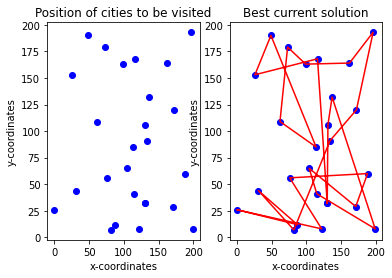


Final distance: 987.1930970408357


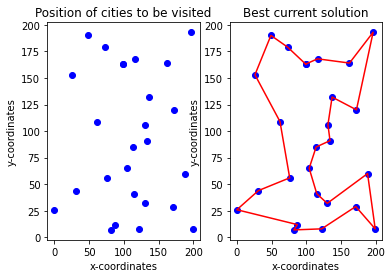

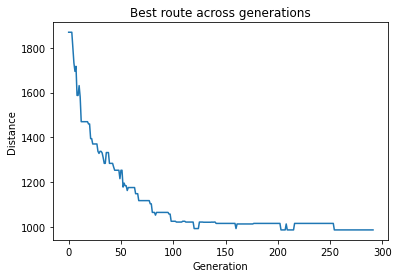

The optimal route found is: 
(99,163) -> (116,168) -> (162,164) -> (196,193) -> (172,120) -> (137,132) -> (131,106) -> (134,91) -> (114,85) -> (104,65) -> (115,41) -> (130,32) -> (188,60) -> (199,8) -> (171,29) -> (122,8) -> (82,7) -> (87,12) -> (0,26) -> (31,44) -> (76,56) -> (62,109) -> (26,153) -> (49,190) -> (73,179) -> (99,163)
Total time execution time:  5.3999714851379395


In [ ]:
get_user_selection()
start_time = time.time() #measure execution time
bestRoute = geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
pretty_print_route(bestRoute)
end_time = time.time()
total_time = end_time - start_time
print('Total time execution time: ', total_time)

Run the function with our assumptions to see how distance has improved in each generation

---
### **10) What other parameters, design choices, initialization and configuration steps are relevant to your design and implementation?**
---
Other aspects that are relevant to the algorithm implementation include the parameters that are passed to the geneticAlgorithm()/geneticAlgorithmPlot() functions. For example the **population size** plays an important role on the performance of the program and adds to the diversity of the population. As explained in the course's textbook, a larger population brings more diversity and sometimes it "balances out the need for mutation" (Hurbans 126). However, this could also mean that our implementation takes more computational resources than a traditional solution to the problem.

The **Elite Size** parameter also plays a key role in the algorithm. This parameter affects the exploitation and exploration aspects of the implementation. The larger the size of this parameter, the more exploitation there is, since the individuals with higher fitness will be retained throughout the generations.  This paremeter is also combined with a **mutation rate** which is another configurable parameter that induces more diversity to the population's offspring. It is important to experiment with the different possible configurations of these parameters and find values that maintain a good balance between exploration and exploitation. As explained by Hurbans, too much diversity "may deteriorate good-performaing individuals," but lower diversity may also result in stagnation of our solution.

The **number of offspring** is a relevant design choice for this GA implementation. For this specific program the offspring size remains constant, that is, the initial population size is maintained as the population size throughout all the generations. This means that those individuals that were not in the elite or those that were not selected for breeding were killed to maintain the population size fixed. It would be interesting to implement an algorithm with a dynamic population size, which can improve diversity to our population.




# Putting the pieces of code together:

In [ ]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import time

OPTIONS_AVAILABLE_DICT = {
                            'selection':{'1':'Roulette Wheel Selection with Pandas','2':'Roulette Wheel Selection with lists','3':'Tournament Selection'},
                            'breeding':{'1':'Order Crossover', '2':'Same Value-Position Crossover', '3':'Improved Order Crossover'},
                            'mutation':{'1':'Swap Mutation', '2':'Inversion Mutation', '3':'Scramble Mutation'},
                            'stop condition':{'1':'Specified number of Generations', '2':'Stop if no improvement (Stagnation)'}
                        }

USER_SELECTED_OPTIONS_DICT = {'selection':'1', 'breeding':'1', 'mutation':'1', 'stop condition':'1'}

random.seed(10) #Set seed to keep getting consistent results

"""## Create necessary classes and functions

Create class to handle "cities"
"""

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

"""Create a fitness function"""

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

"""## Create our initial population

Route generator
"""

def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

"""Create first "population" (list of routes)"""

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

"""## Create the genetic algorithm

Rank individuals
"""

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

"""Create a selection function that will be used to make the list of parent routes"""

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#Roulette wheel selection more similar to the one in the textbook (with elitism)
def roulette_wheel_selection(popRanked, eliteSize):
    '''Takes popRanked list of tuples of the format [(index,fitness),...] and size of elite group. Returns a list of the indices of the selected individuals'''
    selectionResults = []
    population_sum = sum(individual[1] for individual in popRanked) #sum of individual fitnesses
    popRanked_probabilities = [(individual[0], individual[1] / population_sum) for individual in popRanked] #convert popRanked into list of format [(index,probability),...]
    slices = []
    total = 0
    for i in range(eliteSize): #preserve elite individuals
        selectionResults.append(popRanked[i][0])
    for i in range(len(popRanked)):
        individual = popRanked_probabilities[i]
        slices.append([i,total, total + individual[1]]) #index 1 stores the probability of that individual
        total += individual[1]
    for i in range(len(popRanked) - eliteSize):
        spin = random.random()
        result = [s[0] for s in slices if s[1] < spin <= s[2]]
        selectionResults.append(popRanked[result[0]][0]) #store the original population index of the selected individual
    return selectionResults

#Tournament selection with elitism implementation
def tournament_selection(popRanked, eliteSize):
    tournament_size = 5
    selectionResults = []
    for i in range(eliteSize): #preserve elite individuals
        selectionResults.append(popRanked[i][0])
    for i in range(len(popRanked)-eliteSize):
        competitors = random.sample(popRanked, tournament_size) #get random sample of population of size tournament_size
        winner = max(competitors, key = lambda individual: individual[1]) #select winner out of the sample based on fitness
        selectionResults.append(winner[0])
    return selectionResults

"""Create mating pool"""

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

"""Create a crossover function for two parents to create one child"""

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def breed_same_value(parent1, parent2):
    ind_same_value = []
    stack_diff_value = []
    child = []
    for i in range(len(parent1)):
        if parent1[i] == parent2[i]: #if parent1 and parent2 share the same gene at same position
            ind_same_value.append(i)
        else:
            stack_diff_value.append(parent1[i])
    random.shuffle(stack_diff_value)
    if not ind_same_value: #if parents do not share any genes as the same position
        return breed(parent1, parent2)
    for i in range(len(parent1)):
        if i in ind_same_value:
            child.append(parent1[i])
        else:
            child.append(stack_diff_value.pop())
    return child

def breed_ordered(parent1, parent2):
    child = []
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    gene_range_p1 = range(startGene,endGene) #store indexes of the selected genes from parent1
    gene_range_values_p1 = parent1[startGene:endGene] #store values of selected genes from parent1
    for i in range(len(parent1)):
        if i in gene_range_p1: #if indexes of selected genes have been reached, append them in the same order as they were in parent1
            child.append(parent1[i])
        else:
            for j in range(len(parent2)):
                #if indexes of selected genes not reached, append genes from parent 2 such that duplicates are not allowed
                if parent2[j] not in gene_range_values_p1 and parent2[j] not in child:  
                    child.append(parent2[j])
                    break
    return child


"""Create function to run crossover over full mating pool"""

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        if USER_SELECTED_OPTIONS_DICT['breeding'] == '1':
            child = breed(pool[i], pool[len(matingpool)-i-1]) #swap mutation
        if USER_SELECTED_OPTIONS_DICT['breeding'] == '2':
            child = breed_same_value(pool[i], pool[len(matingpool)-i-1]) #Same-value-position crossover
        if USER_SELECTED_OPTIONS_DICT['breeding'] == '3':
            child = breed_ordered(pool[i], pool[len(matingpool)-i-1]) #Improved order crossover
        children.append(child)
    return children

"""Create function to mutate a single route"""

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutate_inversion(individual, mutationRate):
    if(random.random() < mutationRate):
        geneA = int(random.random() * len(individual))
        geneB = int(random.random() * len(individual))
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
        individual_copy = individual[:]
        individual_subset_reversed = individual_copy[startGene:endGene]
        individual_subset_reversed = individual_subset_reversed[::-1] #inverse of given subset
        individual[startGene:endGene] = individual_subset_reversed
    return individual

def mutate_scramble(individual, mutationRate):
    if(random.random() < mutationRate):
        geneA = int(random.random() * len(individual))
        geneB = int(random.random() * len(individual))
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
        subset = individual[startGene:endGene]
        subset_scrambled = random.sample(subset,len(subset))
        individual[startGene:endGene] = subset_scrambled
    return individual

"""Create function to run mutation over entire population"""

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        if USER_SELECTED_OPTIONS_DICT['mutation'] == '1':
            mutatedInd = mutate(population[ind], mutationRate) #swap mutation
        if USER_SELECTED_OPTIONS_DICT['mutation'] == '2':
            mutatedInd = mutate_inversion(population[ind], mutationRate) #Inversion mutation
        if USER_SELECTED_OPTIONS_DICT['mutation'] == '3':
            mutatedInd = mutate_scramble(population[ind], mutationRate) #Scramble mutation
        mutatedPop.append(mutatedInd)
    return mutatedPop

"""Put all steps together to create the next generation"""

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    if USER_SELECTED_OPTIONS_DICT['selection'] == '1':
        selectionResults = selection(popRanked, eliteSize) #Roulette with Pandas
    if USER_SELECTED_OPTIONS_DICT['selection'] == '2':
        selectionResults = roulette_wheel_selection(popRanked,eliteSize) #Roulette with lists
    if USER_SELECTED_OPTIONS_DICT['selection'] == '3':
        selectionResults = tournament_selection(popRanked, eliteSize) #Tournament selection
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def plot_route(route):
    x = [city.x for city in route] + [route[0].x] #list of x coordinates + salesman goes back to initial city
    y = [city.y for city in route] + [route[0].y]
    #create and show cities' positions subplots
    plt.subplot(1,2,1)
    plt.scatter(x,y, color = 'b')
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Position of cities to be visited')
    #create and show current optimal route
    plt.subplot(1,2,2)
    plt.plot(x,y,color = 'r',zorder = 2) #draw connecting lines
    plt.scatter(x,y,color = 'b', zorder = 1) #draw dots
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Best current solution')
    plt.show()

def plot_progress(progress):
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best route across generations')
    plt.show()

def get_user_selection():
    for step in OPTIONS_AVAILABLE_DICT:
        print(f"Which option would you like for **{step}** ")
        for option, description in OPTIONS_AVAILABLE_DICT[step].items():
            print(f"Option {option} : {description}")
        while True:
            decision = input(f" Enter your selection for **{step}**: ")
            if decision in OPTIONS_AVAILABLE_DICT[step]:
                USER_SELECTED_OPTIONS_DICT[step] = decision
                break
            else:
                print('Invalid input, try again: ')
                continue
    print('\nYour final selection is: ')
    for step, decision_num in USER_SELECTED_OPTIONS_DICT.items():
        print(f"{step}: {decision_num} {OPTIONS_AVAILABLE_DICT[step][decision_num]}")
    print('Please wait for the program to finish running.')

def pretty_print_route(route):
    print('The optimal route found is: ')
    for city in route:
        print(f"{city} -> ", end='')
    print(route[0]) #Go back to initial city

"""Final step: create the genetic algorithm"""

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) #
    initial_best_route_index = rankRoutes(pop)[0][0]
    initial_best_route = pop[initial_best_route_index]
    plot_route(initial_best_route)

    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    no_improvement_count = 0
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if USER_SELECTED_OPTIONS_DICT['stop condition'] == '2':
            if progress[i+1] <= progress[i] * 1.01: #if improvement is not greater than 1%
                no_improvement_count += 1
                if no_improvement_count == 75: #if solution has not progressed for 75 consecutive generations stop
                    break
            else:
                no_improvement_count = 0 #reset counter if there has been improvement
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1])) #
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    plot_route(bestRoute)

    plot_progress(progress)
    return bestRoute #

"""Run the function with our assumptions to see how distance has improved in each generation"""


"""## Running the genetic algorithm Create list of cities"""
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))



---
### **11) Which (simple) experiments have you run to observe the impact of different design decisions and parameter values? Post their results and your comments.**
---

Some simple experiments done to the algorithm execution include changing the parameters of the geticAlgorithmPlot() function. Let's examine how changing each of them impacts the results of the genetic algorithm:

Running the program with the original parameters values: 
The starter code uses the functions that we discussed in the previous questions. Our team decided to add a menu that allows the user to choose which functions they would like to use.

The parameter values can be adjusted from the function call. Therefore, in order to run the program with minor design adjustments, we just need to run the block of code found below.

Running the original code with popSize = 200, eliteSize=20, mutationRate = 0.01, and generations = 500 with a random seed = 10 we get a final distance of 978.461.

Running the program using the Pandas' dataframe for the wheel selection is too time consuming. It takes 208.10808038711548 seconds to execute according to our measures. Therefore, all the following runs will be done with our implementation of Roullette wheel selection.

In order to easily reproduce the results shown in the next text cell, use the code snippet bellow.

Which option would you like for **selection** 
Option 1 : Roulette Wheel Selection with Pandas
Option 2 : Roulette Wheel Selection with lists
Option 3 : Tournament Selection
 Enter your selection for **selection**: 2
Which option would you like for **breeding** 
Option 1 : Order Crossover
Option 2 : Same Value-Position Crossover
Option 3 : Improved Order Crossover
 Enter your selection for **breeding**: 1
Which option would you like for **mutation** 
Option 1 : Swap Mutation
Option 2 : Inversion Mutation
Option 3 : Scramble Mutation
 Enter your selection for **mutation**: 1
Which option would you like for **stop condition** 
Option 1 : Specified number of Generations
Option 2 : Stop if no improvement (Stagnation)
 Enter your selection for **stop condition**: 2

Your final selection is: 
selection: 2 Roulette Wheel Selection with lists
breeding: 1 Order Crossover
mutation: 1 Swap Mutation
stop condition: 2 Stop if no improvement (Stagnation)
Please wait for the program to finish running

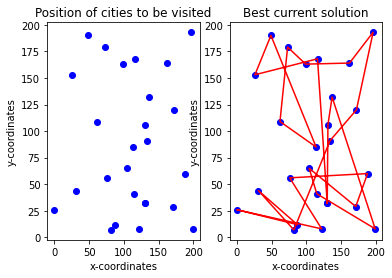

Final distance: 1011.9120429494185


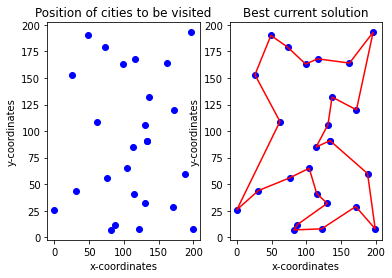

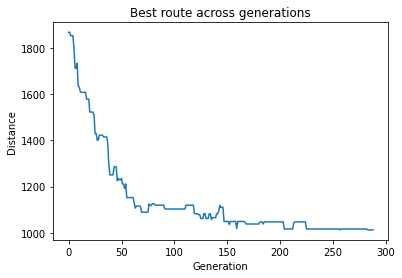

The optimal route found is: 
(134,91) -> (188,60) -> (199,8) -> (171,29) -> (122,8) -> (82,7) -> (87,12) -> (130,32) -> (115,41) -> (104,65) -> (76,56) -> (31,44) -> (0,26) -> (62,109) -> (26,153) -> (49,190) -> (73,179) -> (99,163) -> (116,168) -> (162,164) -> (196,193) -> (172,120) -> (137,132) -> (131,106) -> (114,85) -> (134,91)
Total time execution time:  10.456236124038696 seconds


In [ ]:
get_user_selection()
start_time = time.time() #measure execution time
bestRoute = geneticAlgorithmPlot(population=cityList, popSize=200, eliteSize=20, mutationRate=0.01, generations=500)
pretty_print_route(bestRoute)
end_time = time.time()
total_time = end_time - start_time
print('Total time execution time: ', total_time, 'seconds')

*   Population size (popSize)

  Using the same configuration as above where we choose this:
```
selection: 2 Roulette Wheel Selection with lists
breeding: 1 Order Crossover
mutation: 1 Swap Mutation
stop condition: 1 Specified number of Generations
```
as our final selection, we can see a considerable **DECREASE** in execution time when we decrease our population size by 100. With popSize = 100, we get the same result of an optimal route with a distance of 978 in less time. The average execution time for runs made with popSize = 100 was 10 seconds, 7 seconds faster than the default of popSize = 200 which yields an incredible 41.2% decrease. If we deviate the same amount up to popSize = 300 we can see a considerable **INCREASE** in execution time with runs averaging 22 seconds, which is 5 seconds slower than our intial/default runs. This means that for an increased popSize of 100 we can see a 29.4 increase in execution time. Not only was the execution time more these runs but the "optimal result" found was 993, which is 15 more than what we got for runs with smaller population size. This is an 1.5% increase and it is pretty suprising because one would assume that a larger population would lead to more diversity and increase the opportunity of finding a more optimal solution but that does not seem to be the case. This was especially surprising given that the stopping condition was to do the number of specified generations and not stop if no improvement which would make it reasonable to see worse results with a larger population size. I did some more testing and found that if I increase the generations by 100 to generations=600 with the same paremters and popSize = 300 we get similar results and an execution time that is slightly slower (24 seconds). Even doubling the generations yields the same result with an even slower time (39 seconds). I did one final test and chnaged the stopping condition with popSize = 300 and found a faster execution time (12 seconds) but a result that was considerably less optimal (final distance 1054, 7.8 % increase).

* Elite Size (eliteSize)

  We will be using the same configuration above to test our elite size. Just a reminder, our baseline will be a final distance of 978 and an average execution time of 17 seconds. We will follow the same formula as before and visit equal deviations from the baseline (eliteSize = 20). Lets first explore average results from runs of eliteSize = 10. From the runs we completed we saw an average of 14 seconds for execution time (17.6 % decrease ) and a final distance of 1002 which is 24 more than the baseline (2.5 % increase). At the other end of the spectrum we have eliteSize = 30 which yielded the same average execation time of 14 seconds but an increased final distance of 1018 (4.1% increase). I thought it would be beneficial to experiment a bit more and see how the far end of the elite size spectrum would do so I input eliteSize = 150 and recorded the results. As expected the average execution time was the same as the other deviations (14 seconds) , but the final distance got considerably worse at a final distance of 1452 (48.5% increase). This was probably due to there being lower deversity and we stated before too much diversity "may deteriorate good-performaing individuals," but lower diversity may also result in stagnation of our solution. 

* Mutation Rate (mutationRate)

  We will follow the same steps once again. We will visit results from equal deviations from the baseline (mutationRate = 0.01). First lets explore the lower end at mutationRate = 0.00. It is important to recognize that this essentially means no mutation. At this lower end we see a consistent average of 15 seconds for execution time (11.8 % decrease) and an increased final distance of 1018 (3.5% increase). At the higher end of mutationRate = 0.02 we see a consistent average of 14 seconds (17.6% decrease ) and an increased final distance of 1157 (18.3 increase). It was increase the mutation rate to 10 times the baseline at mutationRate = 0.1  we find that the execution time is consistent at 15 seconds while the final distance is extremly worse at 1966 which is an incredible 101% increase. Once again,  too much diversity "may deteriorate good-performaing individuals."

* Generations

    Finally we will visit generations. For this paramters our baseline is generations=500 so will equal deviations at 250 and 720. For our first, lower end deviation at generations=250 we find that the average execution time is 8 seconds (52.9 % decrease ) with a reasonable increase in final distance at 1016 (3.9% increase). The decreased final time was very much expected here as we are working with 50% less generations so a time roughly 50% shorter is reasonable. At the other end of the spectrum we see that generations=750 yield an average execution time of 21 seconds (23.5% increase) and a final distance of 1000 (2.2% increase).







---
###Conclusion
---
Implementing the GAs are a great approach for solving optimization problems like the TSP since is very efficient because it doesn't require as much of computational resources as other traditional solutions like brute force. There are 6 core steps to the GA life cycle. First of all, creating the population. Then, determining the fitness. In other words, to determine how fit an individual is. Third, selecting the mating pool. We used the fitness proportional selection [or roulette wheel selection]. Next, the breed. We applied the ordered crossover strategy. Fifth, the mutations. We used the ordered crossover strategy. Finally, repeat. After creating the initial population, we looped through many generations until we had our desired result.

---
### Who did what?
---
* Architect (Design of the solution): Mauricio Retana and Juan Pablo Idrovo
* Developer (Coding of the solution) - Mauricio Retana and Reynaldo Williams
* Reporter (Documentation of the solution) - Mauricio Retana, Juan Pablo Idrovo, Reynaldo Williams

---
### Future Improvements:
---
Future improvements to this project would include further error checking when the population is initialized. This is because the cities are chosen randomly in the 200 x 200 grid, but there is no error checking for repeated cities.

Other improvements would include making a web-based version of this program, modifying the code so that 2 children are bred using the crossover functions instead of just 1 child. 

### References

*   Course's textbook - "Grokking Artificial Intelligence Algorithms" by Rishal Hurbans


*   Sample Genetic Algorithm implementation from "Grokking Artificial Intelligence Algorithms"- https://github.com/rishal-hurbans/Grokking-Artificial-Intelligence-Algorithms/blob/master/ch04-evolutionary_algorithms/knapsack_genetic_algorithm.py


*   Video from "The Coding Train" - https://www.youtube.com/watch?v=hnxn6DtLYcY


*   "Evolution of a salesman, a complete genetic algorithm tutorial for Python" by Eric Stoltz (used as starter code)- https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35


*   Rubicite Interactive - https://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/Order1CrossoverOperator.aspx


*   Article from GeeksforGeeks - https://www.geeksforgeeks.org/mutation-algorithms-for-string-manipulation-ga/


*   Article from Hindawi - https://www.hindawi.com/journals/cin/2017/7430125/


* Article from Vijini Mallawaarachchi - https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3

